In [105]:
import os
import math
from tqdm import tqdm

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np


## Loading the dataset and encoding the labels

In [84]:
VOC_train = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='train', 
                                download=False, 
                                transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Resize([224, 224])]
                                                            ),
                                )

VOC_val = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='val', 
                                download=False, 
                                transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Resize([224, 224])]
                                                            ),
                                )

In [62]:
class_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

num_classes = len(class_labels)

In [63]:
def fixVOC(dataset, num_classes=20):
    data=[]
    for idx, (img,metadata) in tqdm(enumerate(dataset)):
        label = torch.zeros(num_classes)
        for obj in metadata['annotation']['object']:
            label[class_labels.index(obj['name'])] = 1  
        data.append((img, label))
    return data

data_train = fixVOC(VOC_train)
data_val = fixVOC(VOC_val)
    
len(data_train), len(data_val)

5717it [01:02, 90.92it/s] 
5823it [00:50, 114.19it/s]


(5717, 5823)

In [68]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32, shuffle=True)

for batch in train_loader:
    print(batch[0].size())
    break

torch.Size([32, 3, 224, 224])


## Build the network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


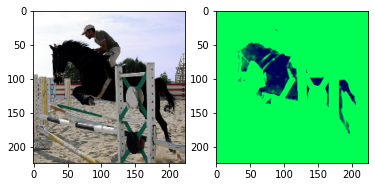

In [213]:
n = 3
conv = nn.Conv2d(n, n, kernel_size=3, padding=1, groups=n,)
conv.weight.requires_grad=False
conv.weight[0,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))
conv.weight[1,:,:,:] = torch.nn.Parameter(5*torch.ones((1,3,3)))
conv.weight[2,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))

img = data_train[0][0]

img_convd = conv(img)
plt.subplot(121)
plt.imshow(np.transpose(img,(1,2,0)))
plt.subplot(122)
plt.imshow(np.transpose(img_convd.detach().numpy(),(1,2,0)))

In [218]:
class SepBlock(nn.Module):
    def __init__(self, n_in, n_out, res):
        super().__init__()
        self.n1 = n_in
        self.n2 = n_out
        self.conv_depth = nn.Conv2d(n_in, n_in, kernel_size=3, padding=1, groups=n_in)
        self.conv_point = nn.Conv2d(n_in, n_out, kernel_size=1, padding=0, groups=1)
        self.batch_norm = nn.BatchNorm2d(num_features=n_out)
        self.res = res

    def forward(self, x):
        out = x
        out = self.conv_depth(out)
        out = self.conv_point(out)
        out = self.batch_norm(out)
        out = torch.relu(out)
        if self.res:
            return out + x
        else:
            return out

class SepNet(nn.Module):

    #TODO: adjust the amount of maxpools to be invaiant of the number of 'steps'

    def __init__(self, n1=16, n2=32, n3=256, n_fc1=128, n_fc2=20, n_blocks=4):
        super().__init__()

        self.n1 = n1
        self.n2 = n2
        self.n3 = n3
        self.n_fc1 = n_fc1
        self.n_fc2 = n_fc2
        self.n_blocks = n_blocks

        self.conv1 = nn.Conv2d(3, n1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=3, padding=1)
        
        # the separable convolution + res blocks (there is a res whenever there is no dimension change)
        inc = int(math.log(n3//n2, 2))
        step = n_blocks / inc
        sep_list = []
        n, n_out = 1, n2
        for i in range(n_blocks):
            n_in = n_out
            if round(n*step) == i+1:
                n+=1
                n_out *= 2
                sep_list.extend((nn.MaxPool2d(2), SepBlock(n_in, n_out, res=False)))
            else:
                sep_list.append(SepBlock(n_in, n_out, res=True))
        self.sepconvs = nn.Sequential(*sep_list)

        self.fc1 = nn.Linear(7*7*n3, n_fc1)
        self.fc2 = nn.Linear(n_fc1, n_fc2)

    def forward(self, x):
        out = x

        # two initial conv2d layers (B,3,224,224) ---> (B,32,56,56)
        out = torch.max_pool2d(torch.relu(self.conv1(out)), 2)
        out = torch.max_pool2d(torch.relu(self.conv2(out)), 2)

        # sep + res blocks (B,32,56,56) ---> (B,128,7,7)
        out = self.sepconvs(out)
        
        # 2 fc blocks (B,128*7*7) ---> (B,20)
        out = out.view(-1, 7*7*self.n3)
        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))

        return out


In [220]:
net = SepNet()

im = torch.randn((1, 3, 224, 224))
im2 = net(im)

im.shape, im2.shape

tensor([[0.4946, 0.5092, 0.4684, 0.4406, 0.4396, 0.5567, 0.4956, 0.4525, 0.5315,
         0.5294, 0.5000, 0.5214, 0.5082, 0.5077, 0.5014, 0.5499, 0.5377, 0.5515,
         0.4779, 0.5091]], grad_fn=<SigmoidBackward0>)

## Train